In [1]:
# Indata.
# Produktion (kWh) - Från Ferroamp.
# Import (kWh), Export (kWh) - Från elhandel räkning / api https://developer.tibber.com/explorer.
# Pris export (öre/kWh) - Medelpriset vi fått per såld kWh under månaden. Detta är spotpriset viktat efter vår export. Från elhandel räkning / api.
# Pris Import (öre/kWh) - Medelpriset vi betalat per köpt kWh utan moms och skatter. Detta är spotpriset viktat efter vår import. Från elhandel räkning / api.
# Pris Kraftringen (öre/kWh) - Kraftringens rörliga elpris utan moms och skatter. Från https://www.kraftringen.se/privat/el/vara-elpriser/
# Alla priser utan moms.
data = {
    # Månad,    Produktion (kWh), Import (kWh), Export (kWh), Pris export (öre/kWh), Pris Import (öre/kWh), Pris Kraftringen (öre/kWh)
    "2024-12": [           59.22,      536.700,        8.293,                133.08,                 49.78, 116.65/1.25               ],
    "2024-11": [           97.05,      432.588,       43.471,                287.52,                 65.54, 96.82                     ],
    "2024-10": [          403   ,      323.642,      238.258,                 59.47,                 23.60, 39.45                     ],
    "2024-09": [          791   , 40.54+153.996, 185.63+352.888,              42.37,                 25.13, 47.69/1.25                ],
    # Tibber 1-8 september
    #         Import  40.54 kWh =  14.20 kr * 1.25
    #         Export 185.63 kWh = −162.68 kr 
    #         Abonnemang 10.46 kr * 1.25
    # Varberg Energi 9-30 september
    #         Import 153.996 kWh = 34.69 kr * 1.25
    #         Export 352.888 kWh = -65.47 kr
    #         Abonnemang 17.55 kr * 1.25
    # Totalt:
    #         Pris export = (-162.68 + -65.47) / (185.63 + 352.888) = -42.37 öre/kWh
    #         Pris import = (14.20 + 34.69) / (40.54 + 153.996) = 25.13 öre/kWh
    "2024-08": [         1190   ,      116.399,      853.138,                57.10,                  22.33, 64.52/1.25 * 307/459      ], # Approximerat med Nodpools pris.
    "2024-07": [         1235   ,      276.705,      884.978,                34.02,                  39.84, 64.52/1.25                ],
    "2024-06": [         1352   ,      162.222,     1043.889,                44.06,                  71.53, 87.28/1.25                ],
    "2024-05": [         1503   ,      200.002,     1207.817,                30.36,                  54.47, 93.76/1.25                ],
    "2024-04": [          896   ,      230.86 ,      650.512,                55.55,                  55.78, 91.26/1.25                ],
    "2024-03": [          549   ,      255.903,      378.752,                55.74,                  75.72, 90.32/1.25                ],
    "2024-02": [          230   ,      296.75 ,      110.722,                44.70,                  65.59, 81.74/1.25                ],
    "2024-01": [           69.21,      460.218,       20.757,                59.48,                  94.07, 123.68/1.25               ],
    "2023-12": [           45.85,      445.915,        5.981,                87.03,                  81.93, 117.82/1.25               ],
    "2023-11": [          140   ,      328.672,       55.545,                88.32,                  92.96, 127.22/1.25               ],
    "2023-10": [          342   ,      292.687,      203.065,                37.58,                  48.56, 58.78/1.25                ],
    "2023-09": [          858   ,      189.51 ,      677.303,                51.07,                  54.19, 77.55/1.25                ],
    "2023-08": [         1040   ,      167.647,      800.228,                56.93,                  47.79, 83.05/1.25                ],
    "2023-07": [         1401   ,      155.955,     1103.835,                40.28,                  50.66, 63.24/1.25                ],
    "2023-06": [         1750   ,      132.341,     1430.73 ,                82.89,                 120.12, 141.89/1.25               ],
    "2023-05": [         1764   ,      151.801,     1435.235,                54.94,                  88.49, 105.39/1.25               ],
    "2023-04": [         1230   ,      194.71 ,      959.93 ,                71.78,                  82.54, 107.33/1.25               ],
    "2023-03": [          606   ,      276.973,      419.006,                98.41,                  96.91, 141.50/1.25               ],
    "2023-02": [          279   ,      272.988,      154.176,               106.52,                 113.71, 158.79/1.25               ],
    "2023-01": [           95.01,      385.32 ,       24.274,               149.02,                 111.84, 159.20/1.25               ],
    "2022-12": [           47.42,      447.953,        5.775,               261.12,                 271.27, 271.45+36.99+3.9          ],
    "2022-11": [          115.00,      404.086,       30.075,               103.54,                 144.24, 219.67/1.25               ],
    "2022-10": [          432.00,      324.757,      246.547,                89.42,                  82.92, 85.00                     ],
    "2022-09": [          400.00,      336.747,      272.157,               228.55,                   None, 251.89+3.2                ],
    "2022-08": [            None,      392.163,         None,                 None,                   None, 322.69+3.2                ],
    "2022-07": [            None,      376.626,         None,                 None,                   None, 130.61+3.2                ],
    "2022-06": [            None,      310.596,         None,                 None,                   None, 184.69+3.2                ],
    "2022-05": [            None,      410.56 ,         None,                 None,                   None, 144.4+3.2                 ],
    "2022-04": [            None,      401.256,         None,                 None,                   None, 115.07+3.2                ],
    "2022-03": [            None,      422.237,         None,                 None,                   None, 164.87+3.2                ],
    "2022-02": [            None,      394.466,         None,                 None,                   None, 90.71+3.2                 ],
    "2022-01": [            None,      498.1  ,         None,                 None,                   None, 120.2+3.2                 ],
}

# Övriga priser och skatter.
data2 = {
    # Från månad
    # Investering (kr)
    # Överföringsavgift (öre/kWh)
    # Elnät abonnemang (kr/månad)
    # Energiskatt (öre/kWh)
    # Skattereduktion (öre/kWh)
    # Nätnytta (öre/kWh)
    # Tim abonnemang (kr/månad)
    # Kraftringen abonnemang (kr/månad)
    # Fjärrvärme abonnemang (kr/månad)
    # Fjärrvärme pris (öre/kWh)
    "2024-09": {                                                      "Tim abonnemang": 24.3}, # Varberg Energi.
    "2024-01": {"Energiskatt": 42.8, "Elnät abonnemang": 410},
    #            "Fjärrvärme pris": 87.00/1.25, "Fjärrvärme pris (rörligt)": 120.30/1.25, "Fjärrvärme abonnemang": 4670/12/1.25},
    "2023-07": {"Överföringsavgift": 15.00, "Tim abonnemang": 39.2},
    "2023-03": {"Överföringsavgift": 21.60, "Elnät abonnemang": 368},
    "2023-01": {"Energiskatt": 39.2, "Nätnytta": 11},
    #            "Fjärrvärme pris": 80.50/1.25, "Fjärrvärme pris (rörligt)": 111.40/1.25, "Fjärrvärme abonnemang": 4325/12/1.25},
    "2022-10": {                                                      "Tim abonnemang": 31},
    "2022-08": {"Investering": 156265},
    "2022-07": {"Överföringsavgift": 19.60, "Elnät abonnemang": 336},
    "2022-01": {"Överföringsavgift": 18.00, "Elnät abonnemang": 308,  "Kraftringen abonnemang": 36, "Energiskatt": 36, "Nätnytta": 5, "Skattereduktion": 60},
    #            "Fjärrvärme pris": 76.00/1.25, "Fjärrvärme abonnemang": 4080/12/1.25},
}


In [2]:
# Uträkningar

import datetime
import numpy as np
import pandas as pd

# Alla månader.
months = pd.DatetimeIndex((data | data2).keys()).sort_values()

columns = [
    'Pris Kraftringen',
    'Pris Import',
    'Pris export',
    'Produktion',
    'Export',
    'Import',
    'Egenförbrukning',
    'Resultat solceller',
    'Resultat timavläsning',
    'Restskuld',
    'Skattereduktion',
    'Nätnytta',
    'Investering',
    'Överföringsavgift',
    'Energiskatt',
    'Elnät abonnemang',
    'Tim abonnemang',
    'Kraftringen abonnemang'
    ]

df = pd.DataFrame(columns=columns, index=months)
df.index.rename("Datum", inplace=True)

for m, row in data.items():
    if not row[0] is None: df.loc[pd.to_datetime(m), "Produktion"]       = row[0]
    if not row[1] is None: df.loc[pd.to_datetime(m), "Import"]           = row[1]
    if not row[2] is None: df.loc[pd.to_datetime(m), "Export"]           = row[2]
    if not row[3] is None: df.loc[pd.to_datetime(m), "Pris export"]      = row[3]
    if not row[4] is None: df.loc[pd.to_datetime(m), "Pris Import"]      = row[4]
    if not row[5] is None: df.loc[pd.to_datetime(m), "Pris Kraftringen"] = row[5]

df["Investering"] = 0
for m, row in data2.items():
    for k, v in row.items():
        df.loc[pd.to_datetime(m), k] = v

df.ffill(inplace=True)

# Estimera faktisk skattereduktion per år.
# Detta minskar skattereduktionen om exporten är större än importen under ett år.
dfy = pd.DataFrame()
for d in df.index:
    y = datetime.datetime.strptime(str(d.year), "%Y")
    if not y in dfy.index:
        dfy.loc[y, "Import (kWh)"] = 0.0
        dfy.loc[y, "Export (kWh)"] = 0.0
    if not np.isnan(df.loc[d, "Import"]):
        dfy.loc[y, "Import (kWh)"] += df.loc[d, "Import"]
    if not np.isnan(df.loc[d, "Export"]):
        dfy.loc[y, "Export (kWh)"] += df.loc[d, "Export"]
# Estimera export för återstående månader från föregående år.
for i in range(-12, -df.index[-1].month):
    d = df.index[i]
    y = datetime.datetime.strptime(str(df.index[-1].year), "%Y")
    if not np.isnan(df.loc[d, "Import"]):
        dfy.loc[y, "Import (kWh)"] += df.loc[d, "Import"]
    if not np.isnan(df.loc[d, "Export"]):
        dfy.loc[y, "Export (kWh)"] += df.loc[d, "Export"]
for d in dfy.index:
    y = datetime.datetime.strptime(str(d.year), "%Y")
    dfy.loc[y, "Faktisk skattereduktion (öre / kWh)"] = min(60.0, 60.0 * dfy.loc[y, "Import (kWh)"] / dfy.loc[y, "Export (kWh)"])

Restskuld = np.nan
for m in df.index:
    y = datetime.datetime.strptime(str(m.year), "%Y")
    df.loc[m, "Faktisk Skattereduktion"] = dfy.loc[y, "Faktisk skattereduktion (öre / kWh)"]

    #m = df.index[6]
    row = df.loc[m].fillna(0.0)
    #print(m)
    #print(row)
    if row["Produktion"] != 0.0:
        df.loc[m, "Räkning Kraftringen"] = ((row["Pris Kraftringen"]+row["Överföringsavgift"]+row["Energiskatt"])*row["Import"]/100.0+row["Kraftringen abonnemang"])*1.25 - \
            (row["Pris export"]+row["Faktisk Skattereduktion"]+row["Nätnytta"])*row["Export"]/100.0
    df.loc[m, "Räkning Kraftringen utan solceller"] = ((row["Pris Kraftringen"]+row["Överföringsavgift"]+row["Energiskatt"])*(row["Import"]+row["Produktion"]-row["Export"])/100.0+row["Kraftringen abonnemang"])*1.25

    if row["Tim abonnemang"] != 0.0:
        df.loc[m, "Räkning Tim"] = ((row["Pris Import"]+row["Överföringsavgift"]+row["Energiskatt"])*row["Import"]/100.0+row["Tim abonnemang"])*1.25 - \
            (row["Pris export"]+row["Faktisk Skattereduktion"]+row["Nätnytta"])*row["Export"]/100.0

    row = df.loc[m].fillna(0.0)
    df.loc[m, "Egenförbrukning"] = np.nan
    df.loc[m, "Resultat solceller"] = np.nan
    if row["Produktion"] != 0.0:
        df.loc[m, "Egenförbrukning"] = (row["Produktion"]-row["Export"]) / row["Produktion"]
        df.loc[m, "Resultat solceller"] = row["Räkning Kraftringen utan solceller"] - row["Räkning Kraftringen"]
    df.loc[m, "Resultat timavläsning"] = np.nan
    if row["Tim abonnemang"] != 0.0:
        df.loc[m, "Resultat timavläsning"] = row["Räkning Kraftringen"] - row["Räkning Tim"]

    row = df.loc[m]
    Restskuld_change = 0.0
    if not np.isnan(row["Investering"]):
        Restskuld_change = Restskuld_change + row["Investering"]
    if not np.isnan(row["Resultat solceller"]):
        Restskuld_change = Restskuld_change - row["Resultat solceller"]
    if Restskuld_change != 0.0:
        if np.isnan(Restskuld):
            Restskuld = 0.0
        Restskuld = Restskuld + Restskuld_change
    df.loc[m, "Restskuld"] = Restskuld


/tmp/ipykernel_30515/1085736782.py:47: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.ffill(inplace=True)


In [3]:
# Tabell.
df.style \
    .format_index(lambda x: x.strftime('%Y-%m')).hide(axis="index", names=True) \
    .format(precision=0, na_rep='', thousands=" ",
        formatter={
            #"Pris Kraftringen": "{:.0f} öre/kWh",
            #"Pris Import": "asd",
            #"Pris export": "asd",
            "Egenförbrukning": lambda x: f"{x*100:.0f}%",
        }) \
    .hide(axis="columns", subset=["Nätnytta", "Skattereduktion", "Tim abonnemang", "Kraftringen abonnemang", "Elnät abonnemang", "Investering", "Energiskatt", "Överföringsavgift"])


,Pris Kraftringen,Pris Import,Pris export,Produktion,Export,Import,Egenförbrukning,Resultat solceller,Resultat timavläsning,Restskuld,Faktisk Skattereduktion,Räkning Kraftringen utan solceller,Räkning Kraftringen,Räkning Tim
2022-01,123,,,,,498,,,,,60,1 150,,
2022-02,94,,,,,394,,,,,60,774,,
2022-03,168,,,,,422,,,,,60,1 217,,
2022-04,118,,,,,401,,,,,60,909,,
2022-05,148,,,,,411,,,,,60,1 080,,
2022-06,188,,,,,311,,,,,60,984,,
2022-07,134,,,,,377,,,,,60,937,,
2022-08,326,,,,,392,,,,156 265,60,1 915,,
2022-09,255,,229,400,272,337,32%,1 295,,154 970,60,1 849,554,
2022-10,85,83,89,432,247,325,43%,707,15,154 263,60,942,235,220


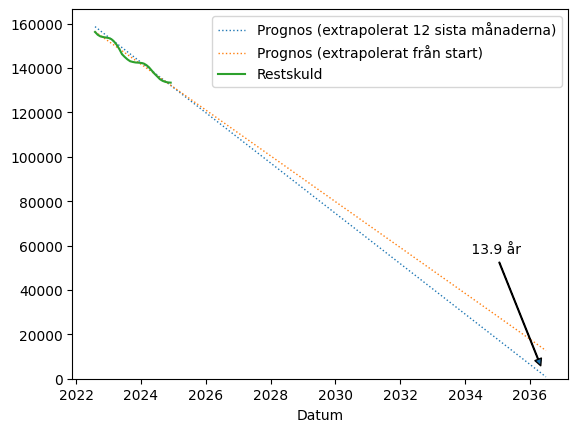

In [4]:
# Visualisera restskuld.

import matplotlib as mpl
import matplotlib.pyplot as plt

dfr = pd.DataFrame(df.loc["2022-08":, "Restskuld"])
t = [t.timestamp() for t in dfr.index]
line = np.polyfit(t[-12:], dfr["Restskuld"].values[-12:], 1)
linetot = np.polyfit(t, dfr["Restskuld"], 1)
zero = pd.to_datetime(-line[1] / line[0], unit="s").to_period("M").to_timestamp()

dfr.loc[dfr.index[0], "Prognos"] = 0.0
dfr.loc[zero, "Prognos"] = 0.0
for t in dfr.index:
    dfr.loc[t, "Prognos"] = line[1] + line[0]*t.timestamp()
dfr.loc[dfr.index[0], "Prognostot"] = 0.0
dfr.loc[zero, "Prognostot"] = 0.0
for t in dfr.index:
    dfr.loc[t, "Prognostot"] = linetot[1] + linetot[0]*t.timestamp()

fig, ax = plt.subplots()

ax.plot(dfr["Prognos"], label="Prognos (extrapolerat 12 sista månaderna)", linewidth=1, linestyle=":")
ax.plot(dfr["Prognostot"], label="Prognos (extrapolerat från start)", linewidth=1, linestyle=":")
ax.plot(dfr["Restskuld"], label="Restskuld")

ax.set_xlabel("Datum")
ax.legend()
ax.set_ylim(bottom=0)
_ = ax.annotate(f"{(zero - dfr.index[0]).total_seconds() / 3600 / 24 / 365.25 : .3n} år",
                va = "center", ha="center",
                xy=(zero, 0), xytext=(0.85, .35), textcoords="axes fraction")
_ = ax.annotate("",
                va = "center", ha="center",
                xy=(zero, 0), xytext=(0.85, .35), textcoords="axes fraction",
                arrowprops=dict(width=0.5, headwidth=5, headlength=5, shrink=0.1))


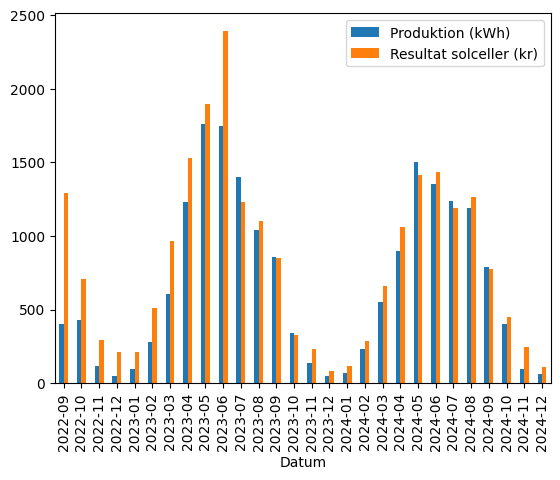

In [5]:
# Visualisera produktion och resultat per månad.

dfr = pd.DataFrame(df.loc["2022-09":, ["Produktion", "Resultat solceller"]])
dfr["Produktion (kWh)"] = dfr["Produktion"]
dfr["Resultat solceller (kr)"] = dfr["Resultat solceller"]
ax = dfr[["Produktion (kWh)", "Resultat solceller (kr)"]].plot.bar()
_ = ax.set_xticklabels([d.strftime("%Y-%m") for d in dfr.index])


            Import (kWh)  Export (kWh)  Faktisk skattereduktion (öre / kWh)
2022-01-01      4719.547       554.554                            60.000000
2023-01-01      2994.519      7269.308                            24.716402
2024-01-01      3486.525      5979.105                            34.987093


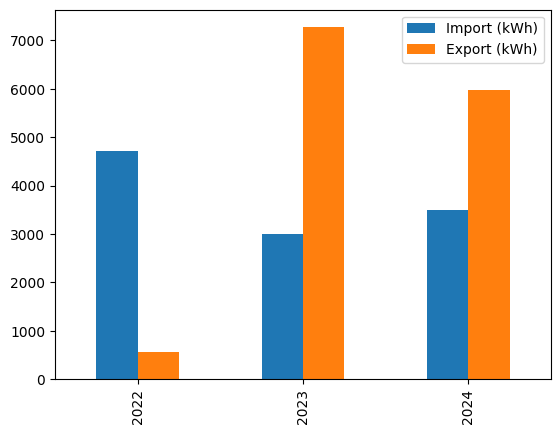

In [6]:
# Visualisera import, export och skattereduktion per år.
print(dfy)

ax = dfy[["Import (kWh)", "Export (kWh)"]].plot.bar()
_ = ax.set_xticklabels([d.strftime("%Y") for d in dfy.index])
